In [0]:
import numpy as np
import matplotlib.pyplot as plt
import string
import gensim
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
import gensim.models.keyedvectors as word2vec
from numpy.linalg import norm

In [0]:
from sklearn.metrics.pairwise import cosine_similarity

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!unzip '/content/drive/My Drive/Set.zip'

Archive:  /content/drive/My Drive/Set.zip
replace stopwords.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
# Hyper Parameters
classes = 2
batch_size = 32

In [0]:
def accuracy(preds,true):
  correct = 0
  l = preds.shape[0]
  for ex in range(l):
    if (preds[ex] == true[ex]).all():
      correct+=1
  print(correct, " of", l, "predictions were correct")    
  acc = (correct/l)
  return acc    



def Softmax(logits):
    Max = np.max(logits,axis=1)
    logits= logits- Max.reshape(Max.shape[0],1)
    fin = np.sum(np.exp(logits), axis=1)
    return np.exp(logits) / fin.reshape(fin.shape[0],1)

def cross_entropy_loss(y_true,y_pred):
    return -(y_true * np.log2(y_pred+1e-50)).sum()



# Batch Generator


In [0]:
def data_generator(df,labels,batch_size = 32):

  while True:
    start = 0
    stop = batch_size

    total_batches = int(np.ceil(df.shape[0] / batch_size))

    for i in range(total_batches):
      if i == total_batches-1:
          yield (df[start:,:],labels[start:,:])
      else:        
          yield (df[start:stop,:],labels[start:stop,:])
      start = stop
      stop+= batch_size
  


In [0]:
train_labels = []
train_headlines = []
test_labels = []
test_headlines = []

stop_words = []

In [0]:
# Loading the stop words
with open("/content/stopwords.txt", "r") as filestream:
  for line in filestream:
    stop_words.append(line.rstrip())


In [0]:
#Loading the training file
with open("/content/train.txt", "r") as filestream:
  for line in filestream:
    split_w = line.split(',')
    train_labels.append(split_w[0])

    train_headlines.append(split_w[1].rstrip())

In [0]:
#Loading the test file
with open("/content/test.txt", "r") as filestream:
  for line in filestream:
    split_w = line.split(',')
    test_labels.append(split_w[0])
    test_headlines.append(split_w[1].rstrip())

In [0]:
# Removing stop words
for i in range(len(train_headlines)):
  out = train_headlines[i].replace(',', ' ').replace('.', ' ').replace('!', ' ').replace('?', ' ')
  out = out.translate(str.maketrans('', '', string.punctuation))
  out = out.split()
  final = [i for i in out if i not in stop_words]
  string_f =  ' '.join(map(str, final))
  train_headlines[i] = string_f



In [0]:
# Removing stop words
for i in range(len(test_headlines)):
  out = test_headlines[i].replace(',', ' ').replace('.', ' ').replace('!', ' ').replace('?', ' ')
  out = out.translate(str.maketrans('', '', string.punctuation))
  out = out.split()
  final = [i for i in out if i not in stop_words]
  string_f =  ' '.join(map(str, final))
  test_headlines[i] = string_f



In [0]:
# Converting to Numpy arrays
train_labels = np.asarray(train_labels)
train_headlines = np.asarray(train_headlines)
test_labels = np.asarray(test_labels)
test_headlines = np.asarray(test_headlines)

In [0]:
# Loading the embeddings
model = word2vec.KeyedVectors.load_word2vec_format('/content/drive/My Drive/GoogleNews-vectors-negative300.bin.gz', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# Loading words that the embeddings represent
word_vectors = model.wv

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [0]:
# Converting the training set headlines into their respective vector representations
train_headlines_vec = []

for i in range(len(train_headlines)):
  temp_vecs = []
  word_list = train_headlines[i].split()
  for word in word_list:
    if word not in word_vectors:
      continue
    else:
      vec = model[word] 
      temp_vecs.append(vec)
  if(len(temp_vecs) > 0):       
    temp_vecs = np.asarray(temp_vecs)
    mean_vec = np.mean(temp_vecs,axis=0)
    train_headlines_vec.append(mean_vec)
  else:
    train_labels = np.delete(train_labels,[i])  

train_headlines_vec = np.array(train_headlines_vec)


In [0]:
# Converting the test set headlines into their respective vector representations
test_headlines_vec = []

for i in range(len(test_headlines)):
  temp_vecs = []
  word_list = test_headlines[i].split()
  for word in word_list:
    if word not in word_vectors:
      continue
    else:
      vec = model[word] 
      temp_vecs.append(vec)
  if(len(temp_vecs) > 0):       
    temp_vecs = np.asarray(temp_vecs)
    mean_vec = np.mean(temp_vecs,axis=0)
    test_headlines_vec.append(mean_vec)
  else:
    test_labels = np.delete(test_labels,[i])  



test_headlines_vec = np.array(test_headlines_vec)


# Hot Encoding The Labels

In [0]:
train_labels = train_labels.astype(np.int)
test_labels = test_labels.astype(np.int)

In [0]:
shape = (train_labels.shape[0],classes)
encoded = np.zeros(shape)
rows = np.arange(train_labels.shape[0])
encoded[rows,train_labels] = 1
train_labels = encoded


shape = (test_labels.shape[0],classes)
encoded = np.zeros(shape)
rows = np.arange(test_labels.shape[0])
encoded[rows,test_labels] = 1
test_labels = encoded

# Logistic Regression

# Weight intitializations

In [0]:
W = np.zeros((train_headlines_vec.shape[1],classes))
b = np.zeros(classes).reshape(1,classes)
W = W.reshape(-1,classes)

In [0]:
W_past = np.zeros_like(W)
V_past = np.zeros_like(W)
beta_1 = 0.99
beta_2 = 0.99

# Batch Gradient Descent

In [0]:
# Optional
def batch_gd(train_matrix_split,train_labels_split,epochs,lr):
    
    J = []
    global W
    global b
    global W_past
    global V_past
    for ech in range(epochs):
      logits = (np.dot(train_matrix_split,W) + b) 
      probs = Softmax(logits)
      loss = cross_entropy_loss(train_labels_split,probs) 
      loss = loss / train_matrix_split.shape[0]
      J.append(loss)

      # Start computing the gradients

      d_W = np.zeros_like(W)
      d_W = np.dot((probs -  train_labels_split ).T,train_matrix_split).T
      d_b = np.sum(probs - train_labels_split,axis=0)
      d_b = d_b / train_matrix_split.shape[0]
      d_W = d_W / train_matrix_split.shape[0]

      # Updating weights using Adam update
      

      W_past = beta_1 * W_past + (1 - beta_1) * d_W

      V_past = beta_2 * V_past + (1 - beta_2) * np.power(d_W, 2)
      W_hat = W_past / (1 - np.power(beta_1, ech+1))
      V_hat = V_past / (1 - np.power(beta_2, ech+1))
      
      W = W - (lr * W_hat / (np.sqrt(V_hat) + 0.0000001) )
      b = b - lr*d_b
      
    

    
    return J


# Mini Batch Gradient descent

In [0]:
def mini_batch_gd(train_matrix_split,train_labels_split,epochs,lr):
  total_batches = int(np.ceil(train_matrix_split.shape[0] / 1024))
  J = []
  global W
  global W_past
  global V_past
  global b
  train_gen = data_generator(train_matrix_split,train_labels_split,1024)
  for ech in range(epochs):
    for batch in range(total_batches):
      data = next(train_gen)
      logits = (np.dot(data[0],W) + b)
    
      probs = Softmax(logits)
      loss = cross_entropy_loss(data[1],probs) 
      loss = loss / data[0].shape[0]
      J.append(loss)
      # Start computing the gradients

      d_W = np.zeros_like(W)
      d_W = np.dot((probs - data[1]).T,data[0]).T
      
      d_b = np.sum(probs - data[1],axis=0)
      d_b = d_b / data[1].shape[0]
      d_W = d_W / data[0].shape[0]

      # Updating weights
      W_past = beta_1 * W_past + (1 - beta_1) * d_W

      V_past = beta_2 * V_past + (1 - beta_2) * np.power(d_W, 2)
      W_hat = W_past / (1 - np.power(beta_1, ech+1))
      V_hat = V_past / (1 - np.power(beta_2, ech+1))
      W = W - (lr * W_hat / (np.sqrt(V_hat) + 0.00001) )

      b = b - lr*d_b
     
  return J

In [0]:
def predict_meaning(matrix,labels):
  logits = np.dot(matrix,W) + b
  probs = Softmax(logits)
  preds = np.zeros_like(probs)
  index = np.argmax(probs,axis=1).reshape(preds.shape[0],1)
  l = np.arange(len(index)).reshape(preds.shape[0],1)
  preds[l,index] = 1
  acc = accuracy(preds,labels)

  print("The accuracy on the data is: ", acc)
  return preds

In [0]:
# Batch Generator
train_gen = data_generator(train_headlines_vec,train_labels)

In [0]:
loss = mini_batch_gd(train_headlines_vec,train_labels,100,0.001)

In [0]:
preds = predict_meaning(test_headlines_vec,test_labels)

4071  of 5707 predictions were correct
The accuracy on the data is:  0.713334501489399


# KNN

In [0]:
# Initial K
k = 1

In [0]:
def allmax(a):
    if len(a) == 0:
        return []
    all_ = [0]
    max_ = a[0]
    for i in range(1, len(a)):
        if a[i] > max_:
            all_ = [i]
            max_ = a[i]
        elif a[i] == max_:
            all_.append(i)
    return all_

In [0]:
a = [0,3]
b = allmax(a)
b

[1]

In [0]:
def predict_label(dist_vect,train_labels,k):
  #Indices of k smallest distances in the array
  pred_label = np.zeros((1,classes)) 
  votes = np.zeros((1,classes))

  indices = dist_vect[0:k]
  #print(indices)
  for inde in indices:
    ind = np.argmax(train_labels[inde])
    votes[0][ind] += 1

  #print(votes)
  max_list = allmax(votes[0])
  #print(max_list)
  if len(max_list) > 1:
    votes = np.zeros((1,classes))
    for inde in indices[:-1]:
      ind = np.argmax(train_labels[inde])
      votes[0][ind] += 1
    
    lab = np.argmax(votes)
    pred_label[0][lab] = 1  
    return pred_label

  pred_label[0][max_list[0]] = 1  
  return pred_label


In [0]:
def KNN_distances(test_data,test_labels,train_data,train_labels):
  sim_matrix = []

  preds = np.zeros_like(test_labels)
  for i in range(test_data.shape[0]):
    dist_vect = []
    for ex in range(train_data.shape[0]):
      tot = 0
      tot = np.dot(test_data[i], train_data[ex])/ (norm(test_data[i])*norm(train_data[ex]))
      dist_vect.append(tot)
    
    dist_vect = np.argsort(np.negative(dist_vect))  
    sim_matrix.append(dist_vect)


  return np.asarray(sim_matrix)    

In [0]:
def KNN(test_data,test_labels,train_data,train_labels,sim_matrix,k):
  preds = np.zeros_like(test_labels)
  for i in range(sim_matrix.shape[0]):  
    vect = sim_matrix[i]
    pred_label = predict_label(vect,train_labels,k)
    preds[i] = pred_label

  return preds  


In [0]:
tt = test_headlines_vec[0:100]
t_l = test_labels[0:100]

In [0]:
# For K = 1
dist_matrix = KNN_distances(test_headlines_vec,test_labels,train_headlines_vec,train_labels)



In [0]:
dist_matrix

array([[17108,  9636, 13598, ...,  4216, 21933,   412],
       [11007, 14452, 16777, ..., 14766, 13113, 11630],
       [14384,  9096,  7003, ..., 19345,  9120, 21933],
       [16880, 10356, 21912, ..., 14706,  5115,  6129],
       [ 8258,   306,  6411, ..., 14539, 12473, 17242]])

In [0]:
predictions_1 = KNN(test_headlines_vec,test_labels,train_headlines_vec,train_labels,dist_matrix,1)

In [0]:
acc_k_1 = accuracy(predictions_1,test_labels)

4010  of 5707 predictions were correct


In [0]:
# For K = 3

k = 3

predictions_1 = KNN(test_headlines_vec,test_labels,train_headlines_vec,train_labels,dist_matrix,3)

acc_k_1 = accuracy(predictions_1,test_labels)

4130  of 5707 predictions were correct


In [0]:
# For K = 5

k = 5


predictions_1 = KNN(test_headlines_vec,test_labels,train_headlines_vec,train_labels,dist_matrix,5)

acc_k_1 = accuracy(predictions_1,test_labels)

4199  of 5707 predictions were correct


In [0]:
# For K = 7

k = 7

predictions_1 = KNN(test_headlines_vec,test_labels,train_headlines_vec,train_labels,dist_matrix,7)

acc_k_1 = accuracy(predictions_1,test_labels)

4244  of 5707 predictions were correct


In [0]:
# For K = 10

k = 10

predictions_1 = KNN(test_headlines_vec,test_labels,train_headlines_vec,train_labels,dist_matrix,10)

acc_k_1 = accuracy(predictions_1,test_labels)

4235  of 5707 predictions were correct


# Evaluation metrics

In [0]:
def confusion_matrix(predictions,labels,mat):

  for ind,lab in enumerate(labels):
    tr = np.argmax(lab)
    pr = np.argmax(predictions[ind])
    mat[pr,tr] +=1
  return mat

In [0]:
conf_mat = np.zeros((classes,classes))

In [0]:
c = confusion_matrix(predictions_1,test_labels, conf_mat)

In [0]:
accuracy = (c[0,0] + c[1,1]) / np.sum(c)
precision = (c[0,0]) / (c[0,0] + c[0,1])
recall = (c[0,0]) / (c[0,0] + c[1,0])
f1 = (2*precision*recall)/(precision+recall)

# Confusion Matrix

# Confusion matrix for logistic regression


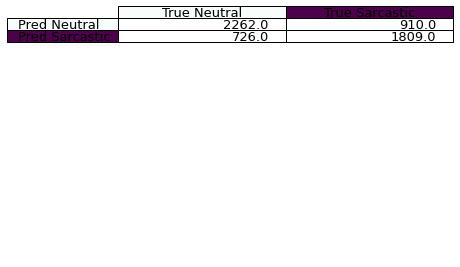

In [0]:

# Prepare table
# Add a table at the bottom of the axes
c_colors = [["w","w"],[ "w","w"]]
columns = ('True Neutral', 'True Sarcastic')
rows = ['Pred Neutral', 'Pred Sarcastic']
colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
plt.axis('tight')
plt.axis('off')

cell_text = c
the_table = plt.table(
                      
                      cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      cellColours = c_colors,
                      colColours = colors,
                      colWidths = [0.5,0.5,0.5],
                      colLabels=columns,
                      fontsize = 0.9,
                      loc='top')

the_table.set_fontsize(13)
plt.show()

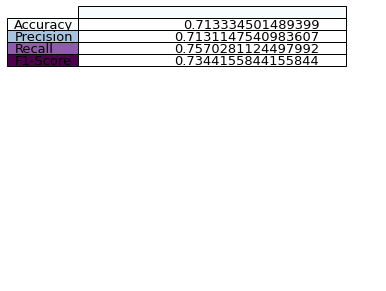

In [0]:

# Prepare table
# Add a table at the bottom of the axes
c_colors = np.asarray(["w","w","w","w"]).reshape(4,1)


rows = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
# Get some pastel shades for the colors
colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
#c_colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
#r_colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
plt.axis('tight')
plt.axis('off')

cell_text = np.asarray([accuracy,precision,recall, f1]).reshape(4,1)
the_table = plt.table(
                      
                      cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      cellColours = c_colors,
                      colColours = colors,
                      colWidths = [0.8,0.8],
                      
                      fontsize = 0.9,
                      loc='top')

the_table.set_fontsize(13)
plt.show()

# Confusion matrix for KNN

# K = 1

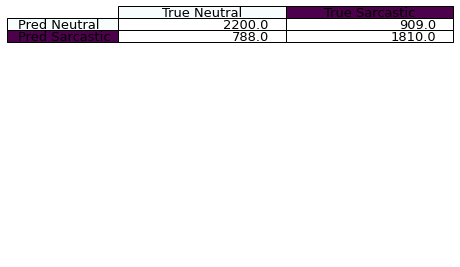

In [0]:

# Prepare table
# Add a table at the bottom of the axes
c_colors = [["w","w"],[ "w","w"]]
columns = ('True Neutral', 'True Sarcastic')
rows = ['Pred Neutral', 'Pred Sarcastic']
colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
plt.axis('tight')
plt.axis('off')

cell_text = c
the_table = plt.table(
                      
                      cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      cellColours = c_colors,
                      colColours = colors,
                      colWidths = [0.5,0.5,0.5],
                      colLabels=columns,
                      fontsize = 0.9,
                      loc='top')

the_table.set_fontsize(13)
plt.show()

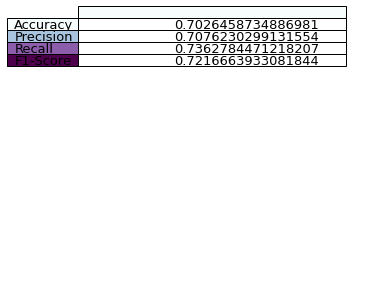

In [0]:

# Prepare table
# Add a table at the bottom of the axes
c_colors = np.asarray(["w","w","w","w"]).reshape(4,1)


rows = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
# Get some pastel shades for the colors
colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
#c_colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
#r_colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
plt.axis('tight')
plt.axis('off')

cell_text = np.asarray([accuracy,precision,recall, f1]).reshape(4,1)
the_table = plt.table(
                      
                      cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      cellColours = c_colors,
                      colColours = colors,
                      colWidths = [0.8,0.8],
                      
                      fontsize = 0.9,
                      loc='top')

the_table.set_fontsize(13)
plt.show()

# K = 3

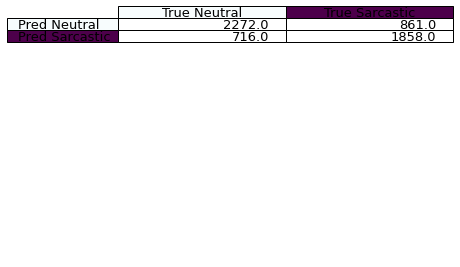

In [0]:

# Prepare table
# Add a table at the bottom of the axes
c_colors = [["w","w"],[ "w","w"]]
columns = ('True Neutral', 'True Sarcastic')
rows = ['Pred Neutral', 'Pred Sarcastic']
colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
plt.axis('tight')
plt.axis('off')

cell_text = c
the_table = plt.table(
                      
                      cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      cellColours = c_colors,
                      colColours = colors,
                      colWidths = [0.5,0.5,0.5],
                      colLabels=columns,
                      fontsize = 0.9,
                      loc='top')

the_table.set_fontsize(13)
plt.show()

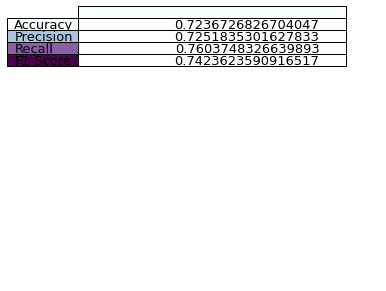

In [0]:

# Prepare table
# Add a table at the bottom of the axes
c_colors = np.asarray(["w","w","w","w"]).reshape(4,1)


rows = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
# Get some pastel shades for the colors
colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
#c_colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
#r_colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
plt.axis('tight')
plt.axis('off')

cell_text = np.asarray([accuracy,precision,recall, f1]).reshape(4,1)
the_table = plt.table(
                      
                      cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      cellColours = c_colors,
                      colColours = colors,
                      colWidths = [0.8,0.8],
                      
                      fontsize = 0.9,
                      loc='top')

the_table.set_fontsize(13)
plt.show()

# K = 5

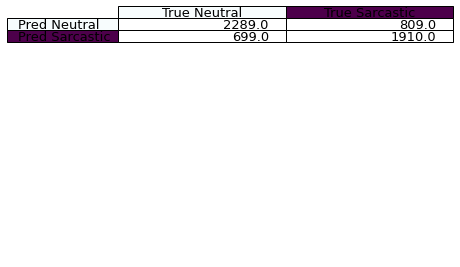

In [0]:

# Prepare table
# Add a table at the bottom of the axes
c_colors = [["w","w"],[ "w","w"]]
columns = ('True Neutral', 'True Sarcastic')
rows = ['Pred Neutral', 'Pred Sarcastic']
colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
plt.axis('tight')
plt.axis('off')

cell_text = c
the_table = plt.table(
                      
                      cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      cellColours = c_colors,
                      colColours = colors,
                      colWidths = [0.5,0.5,0.5],
                      colLabels=columns,
                      fontsize = 0.9,
                      loc='top')

the_table.set_fontsize(13)
plt.show()

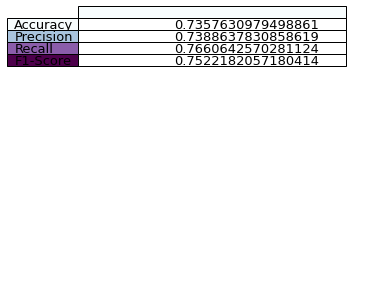

In [0]:

# Prepare table
# Add a table at the bottom of the axes
c_colors = np.asarray(["w","w","w","w"]).reshape(4,1)


rows = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
# Get some pastel shades for the colors
colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
#c_colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
#r_colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
plt.axis('tight')
plt.axis('off')

cell_text = np.asarray([accuracy,precision,recall, f1]).reshape(4,1)
the_table = plt.table(
                      
                      cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      cellColours = c_colors,
                      colColours = colors,
                      colWidths = [0.8,0.8],
                      
                      fontsize = 0.9,
                      loc='top')

the_table.set_fontsize(13)
plt.show()

# K = 7

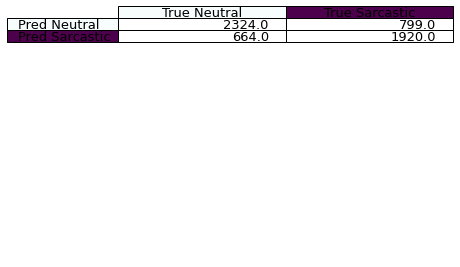

In [0]:

# Prepare table
# Add a table at the bottom of the axes
c_colors = [["w","w"],[ "w","w"]]
columns = ('True Neutral', 'True Sarcastic')
rows = ['Pred Neutral', 'Pred Sarcastic']
colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
plt.axis('tight')
plt.axis('off')

cell_text = c
the_table = plt.table(
                      
                      cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      cellColours = c_colors,
                      colColours = colors,
                      colWidths = [0.5,0.5,0.5],
                      colLabels=columns,
                      fontsize = 0.9,
                      loc='top')

the_table.set_fontsize(13)
plt.show()

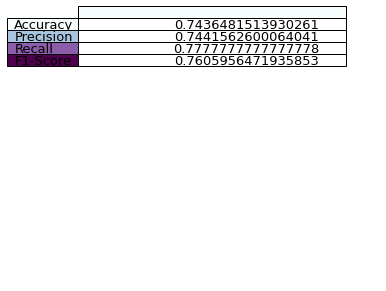

In [0]:

# Prepare table
# Add a table at the bottom of the axes
c_colors = np.asarray(["w","w","w","w"]).reshape(4,1)


rows = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
# Get some pastel shades for the colors
colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
#c_colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
#r_colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
plt.axis('tight')
plt.axis('off')

cell_text = np.asarray([accuracy,precision,recall, f1]).reshape(4,1)
the_table = plt.table(
                      
                      cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      cellColours = c_colors,
                      colColours = colors,
                      colWidths = [0.8,0.8],
                      
                      fontsize = 0.9,
                      loc='top')

the_table.set_fontsize(13)
plt.show()

# K = 10

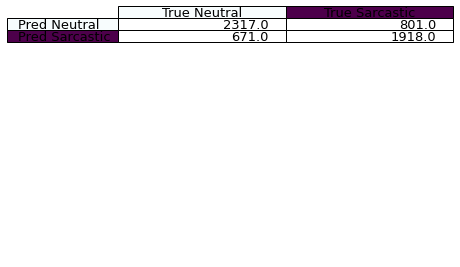

In [0]:

# Prepare table
# Add a table at the bottom of the axes
c_colors = [["w","w"],[ "w","w"]]
columns = ('True Neutral', 'True Sarcastic')
rows = ['Pred Neutral', 'Pred Sarcastic']
colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
plt.axis('tight')
plt.axis('off')

cell_text = c
the_table = plt.table(
                      
                      cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      cellColours = c_colors,
                      colColours = colors,
                      colWidths = [0.5,0.5,0.5],
                      colLabels=columns,
                      fontsize = 0.9,
                      loc='top')

the_table.set_fontsize(13)
plt.show()

# Plotting the metrics

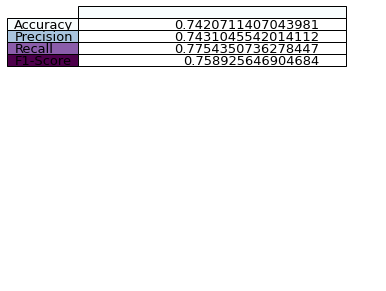

In [0]:

# Prepare table
# Add a table at the bottom of the axes
c_colors = np.asarray(["w","w","w","w"]).reshape(4,1)


rows = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
# Get some pastel shades for the colors
colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
#c_colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
#r_colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
plt.axis('tight')
plt.axis('off')

cell_text = np.asarray([accuracy,precision,recall, f1]).reshape(4,1)
the_table = plt.table(
                      
                      cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      cellColours = c_colors,
                      colColours = colors,
                      colWidths = [0.8,0.8],
                      
                      fontsize = 0.9,
                      loc='top')

the_table.set_fontsize(13)
plt.show()

# Perceptron

In [0]:
weights = np.zeros(len(train_headlines_vec[0]))

In [0]:
train_labels_char = train_labels
test_labels_char = test_labels

train_labels = np.zeros(len(train_labels_char))
test_labels = np.zeros(len(test_labels_char))

for x in range (len(train_labels_char)):
  if (train_labels_char[x] == '0'):
    train_labels[x] = -1;
  else:
    train_labels[x] = 1;

for x in range (len(test_labels_char)):
  if (test_labels_char[x] == '0'):
    test_labels[x] = -1;
  else:
    test_labels[x] = 1;

In [0]:
ech = 0;
while (1):
  for x in range(len(train_headlines_vec)):
    if ((train_labels[x]) * (np.dot(weights,train_headlines_vec[x]))  <= 0):
      weights = weights + (train_labels[x]  * train_headlines_vec[x]);
  ech +=1
  if (ech == 5000):
    break;  

In [0]:
tp = 0
tn = 0
fp =0
fn = 0

for x in range(len(test_headlines_vec)):

  if (test_labels[x]== 1):
    if (np.dot(weights,test_headlines_vec[x]) > 0):
      tp += 1 
    else:
      fn += 1 

  elif (np.dot(weights,test_headlines_vec[x]) < 0):
      tn +=1 
  else:
      fp +=1

In [0]:
conf_matrix = np.array([[tp,fp ] ,[fn, tn]])

In [0]:
a = (tp+tn)/(tp+tn+fp+fn) * 100
print("Accuracy: ", a , " percent" )
p = tp/(tp+fp)
r = tp/(tp + fn)
print("Precision: ", p )
print("Recall: ",r)
f1 = 2* (p*r)/(p + r)
print("F1 Score: ", f1)
  

Accuracy:  61.34571578762923  percent
Precision:  0.5623935782048164
Recall:  0.8503126149319603
F1 Score:  0.6770131771595901


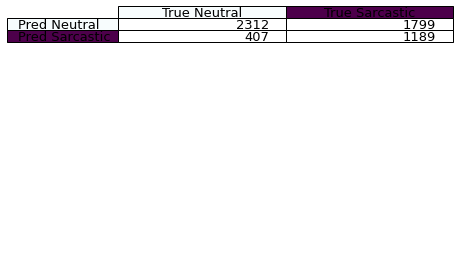

In [0]:
# Prepare table
# Add a table at the bottom of the axes
c_colors = [["w","w"],[ "w","w"]]
columns = ('True Neutral', 'True Sarcastic')
rows = ['Pred Neutral', 'Pred Sarcastic']
colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
plt.axis('tight')
plt.axis('off')

cell_text = conf_matrix
the_table = plt.table(
                      
                      cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      cellColours = c_colors,
                      colColours = colors,
                      colWidths = [0.5,0.5,0.5],
                      colLabels=columns,
                      fontsize = 0.9,
                      loc='top')

the_table.set_fontsize(13)
plt.show()

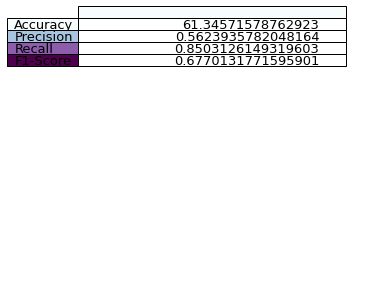

In [0]:

# Prepare table
# Add a table at the bottom of the axes
c_colors = np.asarray(["w","w","w","w"]).reshape(4,1)


rows = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
# Get some pastel shades for the colors
colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
#c_colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
#r_colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
plt.axis('tight')
plt.axis('off')

cell_text = np.asarray([a,p,r, f1]).reshape(4,1)
the_table = plt.table(
                      
                      cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      cellColours = c_colors,
                      colColours = colors,
                      colWidths = [0.8,0.8],
                      
                      fontsize = 0.9,
                      loc='top')

the_table.set_fontsize(13)
plt.show()